In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

import pandas as pd
import math
import csv

from timeit import default_timer as timer

from datetime import datetime

In [2]:
# madgrad
# https://github.com/facebookresearch/madgrad

!pip install madgrad

from madgrad import MADGRAD

In [3]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.8 MB 2.8 MB/s 
     |████████████████████████████████| 138 kB 17.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.4
    Uninstalling urllib3-1.26.4:
      Successfully uninstalled urllib3-1.26.4
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.26
    Uninstalling wandb-0.10.26:
      Successfully uninstalled wandb-0.10.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
earthengine-api 0.1.261 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
allennlp 2.3.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.11.0 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you

In [4]:
import wandb
api_key = '8562886a9639c1f50c4599b9c0a584bddfd1c02e'
wandb.login(key=api_key)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
!pip install timm

     |████████████████████████████████| 376 kB 2.8 MB/s 


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import Adam

from torch.nn.parallel.data_parallel import data_parallel

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

import collections
from collections import defaultdict

import timm
from timm.models.efficientnet import *

import torch.cuda.amp as amp

# Unpack file

In [7]:
_data_dir = "/kaggle/input/covid19512/"

In [8]:
!ls {_data_dir}train/000a312787f2.png

/kaggle/input/covid19512/train/000a312787f2.png


In [9]:
mask_example = cv2.imread(_data_dir + "mask/000a312787f2.png")

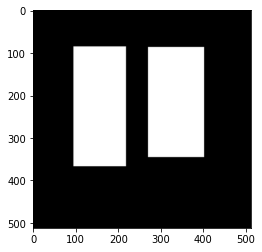

In [10]:
plt.imshow(mask_example, cmap="bone")

In [11]:
train_example = cv2.imread(_data_dir + "train/000a312787f2.png")

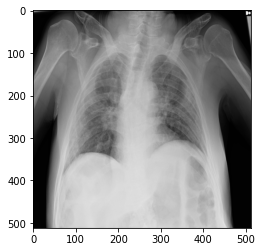

In [12]:
plt.imshow(train_example, cmap="bone")

# Prepare matedata 

In [13]:
study_df = pd.read_csv("/kaggle/input/siim-covid19-detection/train_study_level.csv")
image_df = pd.read_csv("/kaggle/input/siim-covid19-detection/train_image_level.csv")
meta_df = pd.read_csv(_data_dir + "meta.csv")
fold_df = pd.read_csv(_data_dir + "updated_iamge_level.csv")

In [14]:
image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [15]:
_duplicateList_path = _data_dir + 'dublicate.txt'

In [16]:
_duplicateList = []
with open(_duplicateList_path, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        _duplicateList += row

_duplicateList[:5]

['6534a837497d',
 'ea2117b53323',
 'eea3a910fa9e',
 '1ea01196514a',
 '9b1de1c45491']

# Configuration

In [17]:
image_size = 512
data_dir = _data_dir
study_name_to_label = {
    'Negative for Pneumonia'  :0,
    'Typical Appearance'      :1,
    'Indeterminate Appearance':2,
    'Atypical Appearance'     :3,
}
study_label_to_name = { v:k for k,v in study_name_to_label.items()}
num_study_label = len(study_name_to_label)

In [18]:
def make_fold(mode='train-0'):
    if 'train' in mode:
        df = study_df.copy()
        df.loc[:, 'id'] = df.id.str.replace('_study', '')
        df = df.rename(columns={'id': 'study_id'})
        
        fold = fold_df.copy()
        fold.loc[:, 'id'] = fold.id.str.replace('_image', '')
        fold = fold.rename(columns={'id': 'image'})

        #---
        df = df.merge(fold, left_on='study_id', right_on='StudyInstanceUID')
        
        df = df[~df['image'].isin(_duplicateList)]

        #---
        fold = int(mode[-1])
        df_train = df[df.fold != fold].reset_index(drop=True)
        df_valid = df[df.fold == fold].reset_index(drop=True)
        return df_train, df_valid

# Dataset 

In [19]:
class SiimDataset(Dataset):
    def __init__(self, df, augment=None):
        super().__init__()
        self.df = df
        self.augment = augment
        self.length = len(df)

    def __str__(self):
        string  = ''
        string += '\tlen = %d\n'%len(self)
        string += '\tdf  = %s\n'%str(self.df.shape)

        string += '\tlabel distribution\n'
        for i in range(num_study_label):
            n = self.df[study_label_to_name[i]].sum()
            string += '\t\t %d %26s: %5d (%0.4f)\n'%(i, study_label_to_name[i], n, n/len(self.df) )
        return string


    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        #image_file = data_dir + '/%s_640/%s/%s/%s.png' % (d.set, d.study, d.series, d.image)
        image_file = data_dir + '/train/%s.png' % (d.image)
        image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        onehot = d[study_name_to_label.keys()].values

        mask_file = data_dir + '/mask/%s.png' % (d.image)
        mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
        
        if str(mask) == "None":
            mask = np.zeros((image_size, image_size))

        r = {
            'index' : index,
            'd' : d,
            'image' : image,
            'mask' : mask,
            'onehot' : onehot,
        }
        if self.augment is not None: r = self.augment(r)
        return r


def null_collate(batch):
    collate = defaultdict(list)

    for r in batch:
        for k, v in r.items():
            collate[k].append(v)

    # ---
    batch_size = len(batch)
    onehot = np.ascontiguousarray(np.stack(collate['onehot'])).astype(np.float32)
    collate['onehot'] = torch.from_numpy(onehot)

    image = np.stack(collate['image'])
    image = image.reshape(batch_size, 1, image_size,image_size).repeat(3,1)
    image = np.ascontiguousarray(image)
    image = image.astype(np.float32) / 255
    collate['image'] = torch.from_numpy(image)

    mask = np.stack(collate['mask'])
    mask = mask.reshape(batch_size, 1, image_size,image_size)
    mask = np.ascontiguousarray(mask)
    mask = mask.astype(np.float32) / 255
    collate['mask'] = torch.from_numpy(mask)

    return collate

In [20]:
# what is ascontiguousarray
#x = np.arange(6).reshape(2,3)
"""
x = np.array([[1,1,0],[2,0,1], [1,2,3,]])
y = np.ascontiguousarray(x, dtype=np.float32)
print(x.flags['C_CONTIGUOUS'])
print(x)
print(y)
"""

"\nx = np.array([[1,1,0],[2,0,1], [1,2,3,]])\ny = np.ascontiguousarray(x, dtype=np.float32)\nprint(x.flags['C_CONTIGUOUS'])\nprint(x)\nprint(y)\n"

In [21]:
"""
df_train, df_valid = make_fold(mode='train-1')

dataset = SiimDataset(df_valid) #null_augment
print(dataset)


for i in range(10):
    i = np.random.choice(len(dataset))
    r = dataset[i]

    print('index ' , i)
    print(r['d'])
    print(r['onehot'])
    print('')
    plt.figure()
    plt.imshow(r['image'])
    plt.figure()
    plt.imshow(r['mask'], cmap="bone")
"""

'\ndf_train, df_valid = make_fold(mode=\'train-1\')\n\ndataset = SiimDataset(df_valid) #null_augment\nprint(dataset)\n\n\nfor i in range(10):\n    i = np.random.choice(len(dataset))\n    r = dataset[i]\n\n    print(\'index \' , i)\n    print(r[\'d\'])\n    print(r[\'onehot\'])\n    print(\'\')\n    plt.figure()\n    plt.imshow(r[\'image\'])\n    plt.figure()\n    plt.imshow(r[\'mask\'], cmap="bone")\n'

In [22]:
"""
loader = DataLoader(
    dataset,
    sampler = RandomSampler(dataset),
    batch_size  = 8,
    drop_last   = True,
    num_workers = 0,
    pin_memory  = True,
    collate_fn  = null_collate,
)
for t,batch in enumerate(loader):
    if t>5: break

    print(t, '-----------')
    print('index : ', batch['index'])
    print('image : ')
    print('\t', batch['image'].shape, batch['image'].is_contiguous())
    print('mask : ')
    print('\t', batch['mask'].shape, batch['mask'].is_contiguous())
    print('onehot : ')
    print('\t', batch['onehot'])
    print('\t', batch['onehot'].shape, batch['onehot'].is_contiguous())
    print('')
"""

"\nloader = DataLoader(\n    dataset,\n    sampler = RandomSampler(dataset),\n    batch_size  = 8,\n    drop_last   = True,\n    num_workers = 0,\n    pin_memory  = True,\n    collate_fn  = null_collate,\n)\nfor t,batch in enumerate(loader):\n    if t>5: break\n\n    print(t, '-----------')\n    print('index : ', batch['index'])\n    print('image : ')\n    print('\t', batch['image'].shape, batch['image'].is_contiguous())\n    print('mask : ')\n    print('\t', batch['mask'].shape, batch['mask'].is_contiguous())\n    print('onehot : ')\n    print('\t', batch['onehot'])\n    print('\t', batch['onehot'].shape, batch['onehot'].is_contiguous())\n    print('')\n"

# Model 

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        e = efficientnet_b3a(pretrained=True, drop_rate=0.3, drop_path_rate=0.2)
        self.b0 = nn.Sequential(
            e.conv_stem,
            e.bn1,
            e.act1,
        )
        self.b1 = e.blocks[0]
        self.b2 = e.blocks[1]
        self.b3 = e.blocks[2]
        self.b4 = e.blocks[3]
        self.b5 = e.blocks[4]
        self.b6 = e.blocks[5]
        self.b7 = e.blocks[6]
        self.b8 = nn.Sequential(
            e.conv_head, #384, 1536
            e.bn2,
            e.act2,
        )

        self.logit = nn.Linear(1536,num_study_label)
        self.mask = nn.Sequential(
            nn.Conv2d(136, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )


    # @torch.cuda.amp.autocast()
    def forward(self, image):
        batch_size = len(image)
        x = 2*image-1     # ; print('input ',   x.shape)

        x = self.b0(x) #; print (x.shape)  # torch.Size([2, 40, 256, 256])
        x = self.b1(x) #; print (x.shape)  # torch.Size([2, 24, 256, 256])
        x = self.b2(x) #; print (x.shape)  # torch.Size([2, 32, 128, 128])
        x = self.b3(x) #; print (x.shape)  # torch.Size([2, 48, 64, 64])
        x = self.b4(x) #; print (x.shape)  # torch.Size([2, 96, 32, 32])
        x = self.b5(x) #; print (x.shape)  # torch.Size([2, 136, 32, 32])
        #------------
        mask = self.mask(x)
        #-------------
        x = self.b6(x) #; print (x.shape)  # torch.Size([2, 232, 16, 16])
        x = self.b7(x) #; print (x.shape)  # torch.Size([2, 384, 16, 16])
        x = self.b8(x) #; print (x.shape)  # torch.Size([2, 1536, 16, 16])
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        #x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        return logit, mask

In [24]:
"""
batch_size = 2
C, H, W = 3, 512, 512
#C, H, W = 3, 640, 640
image = torch.randn(batch_size, C, H, W).cuda()
mask  = torch.randn(batch_size, num_study_label, H, W).cuda()

net = Net().cuda()
logit, mask = net(image)

print(image.shape)
print(logit.shape)
print(mask.shape)
"""

'\nbatch_size = 2\nC, H, W = 3, 512, 512\n#C, H, W = 3, 640, 640\nimage = torch.randn(batch_size, C, H, W).cuda()\nmask  = torch.randn(batch_size, num_study_label, H, W).cuda()\n\nnet = Net().cuda()\nlogit, mask = net(image)\n\nprint(image.shape)\nprint(logit.shape)\nprint(mask.shape)\n'

# Utils

In [25]:
class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout  #stdout
        self.file = None

    def open(self, file, mode=None):
        if mode is None: mode ='w'
        self.file = open(file, mode)

    def write(self, message, is_terminal=1, is_file=1 ):
        if '\r' in message: is_file=0

        if is_terminal == 1:
            self.terminal.write(message)
            self.terminal.flush()
            #time.sleep(1)

        if is_file == 1:
            self.file.write(message)
            self.file.flush()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass

In [26]:
def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError

In [27]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
        lr +=[ param_group['lr'] ]

    assert(len(lr)==1) #we support only one param_group
    lr = lr[0]

    return lr

# Training

In [28]:
class AmpNet(Net):
    @torch.cuda.amp.autocast()
    def forward(self,*args):
        return super(AmpNet, self).forward(*args)

is_mixed_precision = True  #True #False

## Metric 

In [29]:
from sklearn.metrics import average_precision_score

In [30]:
def np_loss_cross_entropy(probability, truth):
    batch_size = len(probability)
    truth = truth.reshape(-1)
    p = probability[np.arange(batch_size),truth]
    loss = -np.log(np.clip(p,1e-6,1))
    loss = loss.mean()
    return loss


def np_metric_map_curve_by_class(probability, truth):
    num_sample, num_label = probability.shape
    score = []
    for i in range(num_label):
        s = average_precision_score(truth==i, probability[:,i])
        score.append(s)
    score = np.array(score)
    return score

def compute_lovasz_gradient(truth): #sorted
    truth_sum    = truth.sum()
    intersection = truth_sum - truth.cumsum(0)
    union        = truth_sum + (1 - truth).cumsum(0)
    jaccard      = 1. - intersection / union
    T = len(truth)
    jaccard[1:T] = jaccard[1:T] - jaccard[0:T-1]

    gradient = jaccard
    return gradient




def lovasz_hinge_one(logit , truth):
    truth = truth.float()
    sign  = 2. * truth - 1.
    hinge = (1. - logit * sign)
    hinge, permutation = torch.sort(hinge, dim=0, descending=True)
    hinge = F.relu(hinge)

    truth = truth[permutation.data]
    gradient = compute_lovasz_gradient(truth)

    loss = torch.dot(hinge, gradient)
    return loss



def lovasz_loss(logit, truth, mode='hinge'):

    if mode=='hinge':
        lovasz_one = lovasz_hinge_one
    elif mode=='soft_hinge':
        lovasz_one = lovasz_soft_hinge_one
    elif mode=='logistic':
        lovasz_one = lovasz_logistic_one
    elif mode=='exp':
        lovasz_one = lovasz_exp_one
    else:
        raise NotImplementedError

    batch_size = len(truth)
    loss = torch.zeros(batch_size).cuda()
    for b in range(batch_size):
        l, t = logit[b].view(-1), truth[b].view(-1)
        loss[b] = lovasz_one(l, t)


    return loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=8, alpha=.2, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()


## Augment

In [31]:
# #--- flip ---
def do_random_hflip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    return image, mask


# #--- geometric ---
def do_random_rotate(image, mask, mag=15 ):
    angle = np.random.uniform(-1, 1)*mag

    height, width = image.shape[:2]
    cx, cy = width // 2, height // 2

    transform = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
    image = cv2.warpAffine(image, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine(mask, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image, mask


def do_random_scale( image, mask, mag=0.1 ):
    s = 1 + np.random.uniform(-1, 1)*mag
    height, width = image.shape[:2]
    w,h = int(s*width), int(s*height)
    if (h,w)==image.shape[:2]:
        return image, mask

    dst = np.array([
        [0,0],[width,height], [width,0], #[0,height],
    ]).astype(np.float32)

    if s>1:
        dx = np.random.choice(w-width)
        dy = np.random.choice(h-height)
        src = np.array([
            [-dx,-dy],[-dx+w,-dy+h], [-dx+w,-dy],#[-dx,-dy+h],#
        ]).astype(np.float32)
    if s<1:
        dx = np.random.choice(width-w)
        dy = np.random.choice(height-h)
        src = np.array([
            [dx,dy], [dx+w,dy+h], [dx+w,dy],#
        ]).astype(np.float32)

    transform = cv2.getAffineTransform(src, dst)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask


def do_random_stretch_y( image, mask, mag=0.25 ):
    s = 1 + np.random.uniform(-1, 1)*mag
    height, width = image.shape[:2]
    h = int(s*height)
    w = width
    if h==height:
        return image, mask

    dst = np.array([
        [0,0],[width,height], [width,0], #[0,height],
    ]).astype(np.float32)


    if s>1:
        dx = 0#np.random.choice(w-width)
        dy = np.random.choice(h-height)
        src = np.array([
            [-dx,-dy],[-dx+w,-dy+h], [-dx+w,-dy],#[-dx,-dy+h],#
        ]).astype(np.float32)
    if s<1:
        dx = 0#np.random.choice(width-w)
        dy = np.random.choice(height-h)
        src = np.array([
            [dx,dy], [dx+w,dy+h], [dx+w,dy],#
        ]).astype(np.float32)

    transform = cv2.getAffineTransform(src, dst)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask



def do_random_stretch_x( image, mask, mag=0.25 ):
    s = 1 + np.random.uniform(-1, 1)*mag
    height, width = image.shape[:2]
    h = height
    w = int(s*width)
    if w==width:
        return image, mask

    dst = np.array([
        [0,0],[width,height], [width,0], #[0,height],
    ]).astype(np.float32)

    if s>1:
        dx = np.random.choice(w-width)
        dy = 0#np.random.choice(h-height)
        src = np.array([
            [-dx,-dy],[-dx+w,-dy+h], [-dx+w,-dy],#[-dx,-dy+h],#
        ]).astype(np.float32)
    if s<1:
        dx = np.random.choice(width-w)
        dy = 0#np.random.choice(height-h)
        src = np.array([
            [dx,dy], [dx+w,dy+h], [dx+w,dy],#
        ]).astype(np.float32)

    transform = cv2.getAffineTransform(src, dst)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask


def do_random_shift( image, mask, mag=32 ):
    b = mag
    height, width = image.shape[:2]

    image = cv2.copyMakeBorder(image, b,b,b,b, borderType=cv2.BORDER_CONSTANT, value=0)
    mask  = cv2.copyMakeBorder(mask, b,b,b,b, borderType=cv2.BORDER_CONSTANT, value=0)
    x = np.random.randint(0,2*b)
    y = np.random.randint(0,2*b)
    image = image[y:y+height,x:x+width]
    mask = mask[y:y+height,x:x+width]

    return image, mask

###########################################################################################3



# #--- noise ---
def do_random_blurout(image, size=0.20, num_cut=3):
    height, width = image.shape[:2]
    size = int(size*(height+width)/2)
    for t in range(num_cut):
        x = np.random.randint(0,width- size)
        y = np.random.randint(0,height-size)
        x0 = x
        x1 = x+size
        y0 = y
        y1 = y+size
        image[y0:y1,x0:x1]=image[y0:y1,x0:x1].mean()

    return image

def do_random_guassian_blur(image, mag=[0.1, 2.0]):
    sigma = np.random.uniform(mag[0],mag[1])
    image = cv2.GaussianBlur(image, (23, 23), sigma)
    return image

def do_random_noise(image, mag=0.08):
    height, width = image.shape[:2]

    image = image.astype(np.float32)/255
    noise = np.random.uniform(-1,1,size=(height,width))*mag
    image = image+noise

    image = np.clip(image,0,1)
    image = (image*255).astype(np.uint8)
    return image



# # --- intensity ---
def do_random_intensity_shift_contast(image, mag=[0.3,0.2]):
    image = (image).astype(np.float32)/255
    alpha0 = 1 + np.random.uniform(-1,1)*mag[0]
    alpha1 = np.random.uniform(-1,1)*mag[1]
    image = (image+alpha1)
    image = np.clip(image,0,1)
    image = image**alpha0
    image = np.clip(image,0,1)
    image = (image*255).astype(np.uint8)
    return image

#https://answers.opencv.org/question/12024/use-of-clahe/)
def do_random_clahe(image, mag=[[2,4],[6,12]]):
    l = np.random.uniform(*mag[0])
    g = np.random.randint(*mag[1])
    clahe = cv2.createCLAHE(clipLimit=l, tileGridSize=(g, g))

    image = clahe.apply(image)
    return image

# https://github.com/facebookresearch/CovidPrognosis/blob/master/covidprognosis/data/transforms.py
def do_histogram_norm(image, mag=[[2,4],[6,12]]):
    num_bin = 255

    histogram, bin = np.histogram( image.flatten(), num_bin, density=True)
    cdf = histogram.cumsum()  # cumulative distribution function
    cdf = 255 * cdf / cdf[-1]  # normalize

    # use linear interpolation of cdf to find new pixel values
    equalized = np.interp(image.flatten(), bin[:-1], cdf)
    image = equalized.reshape(image.shape)
    return image

In [32]:
def do_valid(net, valid_loader):

    valid_probability = []
    valid_truth = []
    valid_num = 0

    net.eval()
    start_timer = timer()
    for t, batch in enumerate(valid_loader):
        batch_size = len(batch['index'])
        image = batch['image'].cuda()
        onehot = batch['onehot']
        label = onehot.argmax(-1)

        with torch.no_grad():
            #with amp.autocast():
                logit, mask = data_parallel(net,image)
                probability = F.softmax(logit,-1)

        valid_num += batch_size
        valid_probability.append(probability.data.cpu().numpy())
        valid_truth.append(label.data.cpu().numpy())
        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),time_to_str(timer() - start_timer,'sec')),end='',flush=True)

    assert(valid_num == len(valid_loader.dataset))
    #print('')
    #----------------------
    truth = np.concatenate(valid_truth)
    probability = np.concatenate(valid_probability)
    predict = probability.argsort(-1)[::-1]

    loss = np_loss_cross_entropy(probability,truth)
    topk = (predict==truth.reshape(-1,1))
    acc  = topk[:, 0]
    topk = topk.mean(0).cumsum()
    acc = [acc[truth==i].mean() for i in range(num_study_label)]

    #---
    map  = np_metric_map_curve_by_class(probability, truth)*(4/6)

    return [loss, map.mean(), topk[0], topk[1]]

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp


##
# version 1: use torch.autograd
class FocalLossV1(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss


##
# version 2: user derived grad computation
class FocalSigmoidLossFuncV2(torch.autograd.Function):
    '''
    compute backward directly for better numeric stability
    '''
    @staticmethod
    @amp.custom_fwd(cast_inputs=torch.float32)
    def forward(ctx, logits, label, alpha, gamma):
        #  logits = logits.float()

        probs = torch.sigmoid(logits)
        coeff = (label - probs).abs_().pow_(gamma).neg_()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        ce_term1 = log_probs.mul_(label).mul_(alpha)
        ce_term2 = log_1_probs.mul_(1. - label).mul_(1. - alpha)
        ce = ce_term1.add_(ce_term2)
        loss = ce * coeff

        ctx.vars = (coeff, probs, ce, label, gamma, alpha)

        return loss

    @staticmethod
    @amp.custom_bwd
    def backward(ctx, grad_output):
        '''
        compute gradient of focal loss
        '''
        (coeff, probs, ce, label, gamma, alpha) = ctx.vars

        d_coeff = (label - probs).abs_().pow_(gamma - 1.).mul_(gamma)
        d_coeff.mul_(probs).mul_(1. - probs)
        d_coeff = torch.where(label < probs, d_coeff.neg(), d_coeff)
        term1 = d_coeff.mul_(ce)

        d_ce = label * alpha
        d_ce.sub_(probs.mul_((label * alpha).mul_(2).add_(1).sub_(label).sub_(alpha)))
        term2 = d_ce.mul(coeff)

        grads = term1.add_(term2)
        grads.mul_(grad_output)

        return grads, None, None, None


class FocalLossV2(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='sum'):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV2()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        loss = FocalSigmoidLossFuncV2.apply(logits, label, self.alpha, self.gamma)
        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss


##


In [34]:
def train_augment(r):
    image = r['image']
    mask = r['mask']
    # if image[:2].shape != (image_size, image_size):
    #     image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_AREA)

    if 1:
        for fn in np.random.choice([
            lambda image, mask : do_random_scale(image, mask, mag=0.20),
            lambda image, mask : do_random_stretch_y(image, mask, mag=0.20),
            lambda image, mask : do_random_stretch_x(image, mask, mag=0.20),
            lambda image, mask : do_random_shift(image, mask, mag=int(0.20*image_size)),
            lambda image, mask : (image, mask)
        ],1):
            image, mask = fn(image, mask)

        for fn in np.random.choice([
            lambda image, mask : do_random_rotate(image, mask, mag=15),
            lambda image, mask : do_random_hflip(image, mask),
            lambda image, mask : (image, mask)
        ],1):
            image, mask = fn(image, mask)

        # ------------------------
        for fn in np.random.choice([
            lambda image : do_random_intensity_shift_contast(image, mag=[0.5,0.5]),
            lambda image : do_random_noise(image, mag=0.05),
            lambda image : do_random_guassian_blur(image),
            lambda image : do_random_blurout(image, size=0.25, num_cut=2),
            #lambda image : do_random_clahe(image),
            #lambda image : do_histogram_norm(image),
            lambda image : image,
        ],1):
            image = fn(image)

    r['image'] = image
    r['mask'] = mask
    return r

In [35]:
config = {
    "image_size":image_size,
    "start_lr":1e-3,
    #fold = [0, 1, 2, 3, 4]
    "foldlist":[0, 1, 3, 4],
    "batchsize":8,
    "num_iteration":7000,
    "iter_log":200,
    "iter_valid":200
    
}

In [36]:
IDENTIFIER   = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
def run_train():
    
    #wandb.watch(Net, criterion, log="all", log_freq=10)
    
    #for fold in [0,1,2,3,4]:
    for fold in config["foldlist"]:
        
        wandb.init(project="kagglesegg", config=config)
        
        out_dir = "./"
        initial_checkpoint = None
            #out_dir + '/checkpoint/00007700_model.pth' 
            

        #start_lr   = 0.0001#1
        start_lr = config["start_lr"]
        batch_size = config["batchsize"] #14 #22

        #num_iteration = 12000
        num_iteration = config["num_iteration"]
        iter_log    = config["iter_log"]
        iter_valid  = config["iter_valid"]
        iter_save   = list(range(0, num_iteration+1, 200))

        ## setup  ----------------------------------------
        for f in ['checkpoint', 'train', 'valid', 'backup']: os.makedirs(out_dir + '/' + f, exist_ok=True)
        # backup_project_as_zip(PROJECT_PATH, out_dir +'/backup/code.train.%s.zip'%IDENTIFIER)

        log = Logger()
        log.open(out_dir + '/log.train.txt', mode='a')
        log.write('\n--- [START %s] %s\n\n' % (IDENTIFIER, '-' * 64))
        #log.write('\t%s\n' % COMMON_STRING)
        #log.write('\t__file__ = %s\n' % __file__)
        log.write('\tout_dir  = %s\n' % out_dir)
        log.write('\n')

        ## dataset ------------------------------------
        df_train, df_valid = make_fold('train-%d'%fold)
        
        train_dataset = SiimDataset(df_train, train_augment)
        #train_dataset = SiimDataset(df_train, )
        valid_dataset = SiimDataset(df_valid, )

        train_loader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            drop_last   = True,
            num_workers = 4,
            pin_memory  = True,
            worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
            collate_fn  = null_collate,
        )
        valid_loader  = DataLoader(
            valid_dataset,
            sampler = SequentialSampler(valid_dataset),
            batch_size  = 16,
            drop_last   = False,
            num_workers = 4,
            pin_memory  = True,
            collate_fn  = null_collate,
        )

        log.write('train_dataset : \n%s\n'%(train_dataset))
        log.write('valid_dataset : \n%s\n'%(valid_dataset))
        log.write('\n')


        ## net ----------------------------------------
        log.write('** net setting **\n')
        if is_mixed_precision:
            scaler = amp.GradScaler()
            net = AmpNet().cuda()
        else:
            net = Net().cuda()


        if initial_checkpoint is not None:
            f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
            start_iteration = f['iteration']
            start_epoch = f['epoch']
            state_dict  = f['state_dict']
            net.load_state_dict(state_dict,strict=True)  #True
        else:
            start_iteration = 0
            start_epoch = 0


        log.write('net=%s\n'%(type(net)))
        log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
        log.write('\n')

        # -----------------------------------------------
        if 0: ##freeze
            for p in net.block0.backbone.parameters(): p.requires_grad = False


        #optimizer = Lookahead(RAdam(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr), alpha=0.5, k=5)
        #optimizer = RAdam(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)
        #optimizer = MADGRAD( filter(lambda p: p.requires_grad, net.parameters()), lr=start_lr, momentum= 0.9, weight_decay= 0, eps= 1e-06)
        #optimizer = Adam(net.parameters(), lr=start_lr)
        
        optimizer = MADGRAD( filter(lambda p: p.requires_grad, net.parameters()), lr=start_lr, momentum= 0.9, weight_decay= 0, eps= 1e-06)
        
        # num_iteration = 8000
        # iter_log    = 100
        # iter_valid  = 100
        # iter_save   = list(range(0, num_iteration, 100))#1*1000

        log.write('optimizer\n  %s\n'%(optimizer))
        log.write('\n')


        ## start training here! ##############################################
        log.write('** start training here! **\n')
        log.write('   fold = %d\n'%(fold))
        log.write('   is_mixed_precision = %s \n'%str(is_mixed_precision))
        log.write('   batch_size = %d\n'%(batch_size))
        #log.write('   experiment = %s\n' % str(__file__.split('/')[-2:]))
        log.write('                      |----- VALID ---|---- TRAIN/BATCH --------------\n')
        log.write('rate     iter   epoch | loss    map  topk_0 topk_1  | loss0  loss1 loss2 | time          \n')
        log.write('----------------------------------------------------------------------\n')
                  #0.00000   0.00* 0.00  | 0.000  0.000  0.000  0.000  | 0.000  0.000  0.000 |  0 hr 00 min

        def message(mode='print'):
            if mode==('print'):
                asterisk = ' '
                loss = batch_loss
            if mode==('log'):
                asterisk = '*' if iteration in iter_save else ' '
                loss = train_loss

            text = \
                '%0.5f  %5.3f%s %4.2f  | '%(rate, iteration/10000, asterisk, epoch,) +\
                '%4.3f  %4.3f  %4.3f  %4.3f  | '%(*valid_loss,) +\
                '%4.3f  %4.3f  %4.3f  | '%(*loss,) +\
                '%s' % (time_to_str(timer() - start_timer,'min'))

            return text

        #----
        valid_loss = np.zeros(4,np.float32)
        train_loss = np.zeros(3,np.float32)
        batch_loss = np.zeros_like(train_loss)
        sum_train_loss = np.zeros_like(train_loss)
        sum_train = 0
        loss0 = torch.FloatTensor([0]).cuda().sum()
        loss1 = torch.FloatTensor([0]).cuda().sum()
        loss2 = torch.FloatTensor([0]).cuda().sum()


        start_timer = timer()
        iteration = start_iteration
        epoch = start_epoch
        rate = 0
        while  iteration < num_iteration:

            for t, batch in enumerate(train_loader):

                if iteration in iter_save:
                    if iteration != start_iteration:
                        torch.save({
                            'state_dict': net.state_dict(),
                            'iteration': iteration,
                            'epoch': epoch,
                        }, out_dir + '/checkpoint/fold%08d_%08d_model.pth' % (fold,iteration))
                        
                        wandb.save(out_dir + '/checkpoint/fold%08d_%08d_model.pth' % (fold,iteration))
                        
                        pass

                if (iteration % iter_valid == 0):
                    #if iteration!=start_iteration:
                        valid_loss = do_valid(net, valid_loader)  #
                        pass

                if (iteration % iter_log == 0):
                    print('\r', end='', flush=True)
                    log.write(message(mode='log') + '\n')
                    wandb.log({
                        "fold": fold,
                        "epoch": epoch, 
                        "rate": rate,
                        "iterate": iteration/10000,
                        "valid_loss": valid_loss[0], 
                        "valid_map": valid_loss[1],
                        "valid_topk_0": valid_loss[2], 
                        "valid_topk_1": valid_loss[3],
                        "train_ce_loss": loss0, 
                        "train_bce_loss": loss1
                    }, 
                        step=iteration)#


                # learning rate schduler ------------
                rate = get_learning_rate(optimizer)

                # one iteration update  -------------
                batch_size = len(batch['index'])
                image = batch['image'].cuda()
                truth_mask = batch['mask'].cuda()
                truth_mask = F.interpolate(truth_mask, size=(32,32), mode='bilinear', align_corners=False)
                #truth_mask = F.interpolate(truth_mask, size=(16,16), mode='bilinear', align_corners=False)
                onehot = batch['onehot'].cuda()
                label = onehot.argmax(-1)

                #----
                net.train()
                optimizer.zero_grad()
                custom_loss = FocalLossV2()

                if is_mixed_precision:
                    with amp.autocast():
                        logit, mask = data_parallel(net, image)
                        loss0 = F.cross_entropy(logit, label)
                        #loss1 = F.binary_cross_entropy_with_logits(mask, truth_mask)
                        #loss1 = custom_loss(mask,truth_mask)
                        loss1 = lovasz_loss(mask,truth_mask).cuda().sum()

                    #scaler.scale(loss0).backward()
                    #scaler.scale(loss1).backward()
                    #segg = .75*loss2 + .25*loss1
                    scaler.scale(loss0+loss1).backward()
                    scaler.unscale_(optimizer)
                    #torch.nn.utils.clip_grad_norm_(net.parameters(), 2)
                    scaler.step(optimizer)
                    scaler.update()


                else :
                    assert(False)
                    print('fp32')
                    logit, mask = data_parallel(net, image)
                    loss0 = F.cross_entropy(logit, label)
                    loss1 = F.binary_cross_entropy_with_logits(mask, truth_mask)

                    (loss0+loss1).backward()
                    optimizer.step()


                # print statistics  --------
                epoch += 1 / len(train_loader)
                iteration += 1

                batch_loss = np.array([loss0.item(), loss1.item(), loss2.item()])
                sum_train_loss += batch_loss
                sum_train += 1
                if iteration % 100 == 0:
                    train_loss = sum_train_loss / (sum_train + 1e-12)
                    sum_train_loss[...] = 0
                    sum_train = 0

                print('\r', end='', flush=True)
                print(message(mode='print'), end='', flush=True)


        log.write('\n')
        wandb.finish()

In [37]:
run_train()

wandb: Currently logged in as: haplophryne (use `wandb login --relogin` to force relogin)



--- [START 2021-07-26_14-00-10] ----------------------------------------------------------------

	out_dir  = ./

train_dataset : 
	len = 4985
	df  = (4985, 12)
	label distribution
		 0     Negative for Pneumonia:  1370 (0.2748)
		 1         Typical Appearance:  2364 (0.4742)
		 2   Indeterminate Appearance:   868 (0.1741)
		 3        Atypical Appearance:   383 (0.0768)

valid_dataset : 
	len = 1242
	df  = (1242, 12)
	label distribution
		 0     Negative for Pneumonia:   339 (0.2729)
		 1         Typical Appearance:   594 (0.4783)
		 2   Indeterminate Appearance:   214 (0.1723)
		 3        Atypical Appearance:    95 (0.0765)


** net setting **


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


net=<class '__main__.AmpNet'>
	initial_checkpoint = None

optimizer
  MADGRAD (
Parameter Group 0
    eps: 1e-06
    lr: 0.001
    momentum: 0.9
    weight_decay: 0
)

** start training here! **
   fold = 0
   is_mixed_precision = True 
   batch_size = 8
                      |----- VALID ---|---- TRAIN/BATCH --------------
rate     iter   epoch | loss    map  topk_0 topk_1  | loss0  loss1 loss2 | time          
----------------------------------------------------------------------
0.00000  0.000* 0.00  | 1.425  0.175  0.312  0.612  | 0.000  0.000  0.000  |  0 hr 00 min
0.00100  0.020* 0.32  | 1.694  0.264  0.080  0.408  | 1.125  8.054  0.000  |  0 hr 03 min
0.00100  0.040* 0.64  | 1.021  0.305  0.107  0.376  | 1.177  8.019  0.000  |  0 hr 06 min
0.00100  0.060* 0.96  | 1.045  0.296  0.076  0.328  | 1.126  8.019  0.000  |  0 hr 08 min
0.00100  0.080* 1.28  | 1.031  0.307  0.196  0.443  | 1.050  8.013  0.000  |  0 hr 11 min
0.00100  0.100* 1.61  | 1.129  0.307  0.194  0.390  | 1.034  8.

fold,0
epoch,11.87801
rate,0.001
iterate,0.74
valid_loss,0.91162
valid_map,0.35077
valid_topk_0,0.18357
valid_topk_1,0.39775
train_ce_loss,1.02943
train_bce_loss,8.0046
_runtime,6626


fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rate,▁█████████████████████████████████████
iterate,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,▆█▂▂▂▃▂▂▂▂▁▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁▂▂▁▁▁▂▁▂▁▁▁▁
valid_map,▁▅▆▆▆▆▇▆▇▇▇▇▅▆▇▆▇▇▆▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇███
valid_topk_0,█▁▂▁▅▅▅▄▃▅▅▃▂▃▃▂▅▄▅▃▂▃▅▅▄▅▅▅▃▃▄▅▄▇▅▄▅▄
valid_topk_1,█▃▃▁▄▃▃▅▂▄▂▃▂▃▃▁▄▂▄▂▂▁▃▃▃▃▃▄▃▃▃▃▃▅▃▂▃▃
train_ce_loss,▁▅▇▄▇▄▄▆▆▇▄▅▆▅▆▇▅▄█▅▆▆▄▅▅▅▅▄▇▅▆▄▅▃▄▅▆▆
train_bce_loss,▁█████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████



--- [START 2021-07-26_14-00-10] ----------------------------------------------------------------

	out_dir  = ./

train_dataset : 
	len = 4984
	df  = (4984, 12)
	label distribution
		 0     Negative for Pneumonia:  1369 (0.2747)
		 1         Typical Appearance:  2366 (0.4747)
		 2   Indeterminate Appearance:   866 (0.1738)
		 3        Atypical Appearance:   383 (0.0768)

valid_dataset : 
	len = 1243
	df  = (1243, 12)
	label distribution
		 0     Negative for Pneumonia:   340 (0.2735)
		 1         Typical Appearance:   592 (0.4763)
		 2   Indeterminate Appearance:   216 (0.1738)
		 3        Atypical Appearance:    95 (0.0764)


** net setting **
net=<class '__main__.AmpNet'>
	initial_checkpoint = None

optimizer
  MADGRAD (
Parameter Group 0
    eps: 1e-06
    lr: 0.001
    momentum: 0.9
    weight_decay: 0
)

** start training here! **
   fold = 1
   is_mixed_precision = True 
   batch_size = 8
                      |----- VALID ---|---- TRAIN/BATCH --------------
rate     iter   epoc

fold,1
epoch,11.87801
rate,0.001
iterate,0.74
valid_loss,0.89551
valid_map,0.36721
valid_topk_0,0.17136
valid_topk_1,0.3934
train_ce_loss,0.6592
train_bce_loss,8.01887
_runtime,6653


fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rate,▁█████████████████████████████████████
iterate,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▃▃▃▂▂▅▂▂▂▁▂▄▂▂▃▂▂▁▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▃▁▁▁
valid_map,▁▅▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇██▇███
valid_topk_0,█▂▁▃▄▄▇▄▅▄▄▅▅▃▃▃▆▄▃▅▆▅▄▃▄▄▆▃▄▄▄▅▅▄▄▅▃▄
valid_topk_1,█▄▁▂▄▁▅▃▄▂▃▄▅▂▄▅▄▂▄▄▄▄▄▃▄▄▄▃▄▅▄▅▅▄▅▅▃▄
train_ce_loss,▁▇▆▆▆▇█▅▇▇▆▅▆▄█▆▆█▆▅▅▇█▅▇▅▆█▆▇▅▆▅▅█▅▅▄
train_bce_loss,▁█████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████



--- [START 2021-07-26_14-00-10] ----------------------------------------------------------------

	out_dir  = ./

train_dataset : 
	len = 4973
	df  = (4973, 12)
	label distribution
		 0     Negative for Pneumonia:  1365 (0.2745)
		 1         Typical Appearance:  2366 (0.4758)
		 2   Indeterminate Appearance:   860 (0.1729)
		 3        Atypical Appearance:   382 (0.0768)

valid_dataset : 
	len = 1254
	df  = (1254, 12)
	label distribution
		 0     Negative for Pneumonia:   344 (0.2743)
		 1         Typical Appearance:   592 (0.4721)
		 2   Indeterminate Appearance:   222 (0.1770)
		 3        Atypical Appearance:    96 (0.0766)


** net setting **
net=<class '__main__.AmpNet'>
	initial_checkpoint = None

optimizer
  MADGRAD (
Parameter Group 0
    eps: 1e-06
    lr: 0.001
    momentum: 0.9
    weight_decay: 0
)

** start training here! **
   fold = 3
   is_mixed_precision = True 
   batch_size = 8
                      |----- VALID ---|---- TRAIN/BATCH --------------
rate     iter   epoc

fold,3
epoch,11.91626
rate,0.001
iterate,0.74
valid_loss,0.97168
valid_map,0.34034
valid_topk_0,0.1555
valid_topk_1,0.39633
train_ce_loss,0.90319
train_bce_loss,8.00707
_runtime,6641


fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rate,▁█████████████████████████████████████
iterate,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▄▃▃▂▃▄▄▅▂▂▂▂▂▂▂▁▂▂▂▂▃▁▂▃▂▃▁▁▁▁▁▁▁▃▂▂▂
valid_map,▁▅▆▆▆▅▆▅▄▆▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇██▇▇███▇▇██
valid_topk_0,▅▄▂▂▇▃▃▂▂▃▄▃▄▇▅▄▅▁▅▅▄▆▄▆▆▅▄▆█▄▅▄▆▄▅▆▆▄
valid_topk_1,▄▃▅▁▇▅▆▂▂▄▃▆▆▅▆▇▇▂▇▅▇▇▃▆▃▆▇▇█▆▆▅▇▇██▇▇
train_ce_loss,▁▅▅▅▇▄▃▆▄▅▃▄▄▅▆▅▆▅▅▄▄█▄▃▆▅▆▆▅▅▅▅▄▆▄▄▃▄
train_bce_loss,▁█████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████



--- [START 2021-07-26_14-00-10] ----------------------------------------------------------------

	out_dir  = ./

train_dataset : 
	len = 4988
	df  = (4988, 12)
	label distribution
		 0     Negative for Pneumonia:  1365 (0.2737)
		 1         Typical Appearance:  2373 (0.4757)
		 2   Indeterminate Appearance:   869 (0.1742)
		 3        Atypical Appearance:   381 (0.0764)

valid_dataset : 
	len = 1239
	df  = (1239, 12)
	label distribution
		 0     Negative for Pneumonia:   344 (0.2776)
		 1         Typical Appearance:   585 (0.4722)
		 2   Indeterminate Appearance:   213 (0.1719)
		 3        Atypical Appearance:    97 (0.0783)


** net setting **
net=<class '__main__.AmpNet'>
	initial_checkpoint = None

optimizer
  MADGRAD (
Parameter Group 0
    eps: 1e-06
    lr: 0.001
    momentum: 0.9
    weight_decay: 0
)

** start training here! **
   fold = 4
   is_mixed_precision = True 
   batch_size = 8
                      |----- VALID ---|---- TRAIN/BATCH --------------
rate     iter   epoc

fold,4
epoch,11.87801
rate,0.001
iterate,0.74
valid_loss,1.06836
valid_map,0.32281
valid_topk_0,0.16626
valid_topk_1,0.44713
train_ce_loss,1.38255
train_bce_loss,8.0008
_runtime,6680


fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rate,▁█████████████████████████████████████
iterate,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,█▃▃▂▃▅▃▃▂▅▂▂▂▁▂▂▂▃▁▁▁▂▁▂▂▂▃▄▁▁▃▂▁▅▂▁▃▄
valid_map,▁▆▆▆▇▅▇▅▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇
valid_topk_0,▃▁▁▃▄▅▂▂▃▅▄▆▆▅▃▄▃▂▃▃▃▃▅▅▃▅▅█▃▄▆▂▄▃▂▅▂▄
valid_topk_1,▄▅▂▄▅▆▇▁▆▅▄▅▆▆▇▃▅▃▄▆▄▇▅▅▆▆▇█▅▇█▄▇▇▅▆▃█
train_ce_loss,▁▇▄▇▃▃▄▆▄▇▄▄▆▄█▅▆▅▅▄▅▄▄▄▇▅▄▇▄▅▅▅▆▆▅▃▃▇
train_bce_loss,▁█████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
